In [1]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [2]:
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from astropy.io import fits
import aplpy

/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/core.py:14: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  import mpl_toolkits.axes_grid.parasite_axes as mpltk


In [9]:
# the output catalogs (after photoz and mass runs)
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats/'

# the output catalogs (from graham)
name_tag = '_localrun'
detect_limit = '_22.4'
cat_output_no_irac_nir_mass_name = graham_output_dir+'cat_out'+name_tag+'_nonirirac_il'+detect_limit+'_formass.fits'
cat_output_no_irac_mass_name = graham_output_dir+'cat_out'+name_tag+'_noirac_il'+detect_limit+'_formass.fits'
cat_output_no_nir_mass_name = graham_output_dir+'cat_out'+name_tag+'_nonir_il'+detect_limit+'_formass.fits'
cat_output_full_mass_name = graham_output_dir+'cat_out'+name_tag+'_allphot_il'+detect_limit+'_formass.fits'
cat_names = [cat_output_no_irac_nir_mass_name, cat_output_no_irac_mass_name, cat_output_no_nir_mass_name, cat_output_full_mass_name]
filter_selections = ['optical only','no irac / with nir','no nir / with irac','full photometry']

In [10]:
# check massives (in optical+irac phot catalog)
cat_output_c20added = Table.read(cat_output_no_nir_mass_name.replace('.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]

# selection condition
massive_cut=11.2
# cond = (cat_output_c20added['MASS_MED_massrun']>massive_cut) & (cat_matched['lp_mass_med']<(massive_cut-0.5))  # fake massive
cond = (cat_output_c20added['MASS_MED_massrun']>massive_cut)  # my massive

massive_gals_selected = cat_output_c20added[cond]
massive_gals_selected.write('lp_massive_gal_check/lp_massive_gal_check.fits',overwrite=True)

# z-slice
massive_gals_selected_z = massive_gals_selected[abs(massive_gals_selected['Z_ML']-0.35)<0.15]
massive_gals_selected_z.rename_columns(['RA_1','DEC_1','ID_1'],['RA','DEC','ID'])
massive_gals_selected_z = massive_gals_selected_z['RA','DEC','ID','Z_ML','lp_zPDF','MASS_MED_massrun','lp_mass_med']
print(len(massive_gals_selected_z))

In [44]:
def find_patch(ra, dec, field='COSMOS_deep'):
    patch_list = []
    cat_patches = Table.read('tract_patches/'+field+'_patches.fits')
    for patch in cat_patches:
        if ra < patch['corner0'][0] and ra > patch['corner1'][0] and dec < patch['corner2'][1] and dec > patch['corner1'][1]:
            patch_list.append([str(patch['tract']), str(patch['patch'])])

    return patch_list

In [57]:
# add tract and patch info

tract_list = []
patch_list = []
for gal in massive_gals_selected_z:
    tract,patch = find_patch(gal['RA'], gal['DEC'], field='COSMOS_deep')[0]
    tract_list.append(tract)
    patch_list.append(patch)

col_tract = Column(name='TRACT',data=tract_list)
col_patch = Column(name='PATCH',data=patch_list)
massive_gals_selected_z.add_columns([col_tract,col_patch])
massive_gals_selected_z.write('lp_massive_gal_check/lp_massive_gal_check_z.fits',overwrite=True)

In [58]:
# load v9 catalog
cat_v9 = Table.read('/Volumes/LejaySSD/v9_cats/COSMOS_deep_v9.fits')
cat_v9 = cat_v9[cat_v9['inside_u'] == True]
cat_v9 = cat_v9[cat_v9['MASK'] == 0]  # unmasked
cat_v9 = cat_v9[cat_v9['OBJ_TYPE'] == 0]  # galaxies
cat_v9 = cat_v9['ID','RA','DEC']

4414618 0.4382 0.437 11.3099 11.29963


/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6

4448244 0.3062 0.2632 11.5962 11.39449


/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6

4579090 0.3883 0.3494 11.234 10.80592


/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6

4584888 0.4943 0.3607 11.6503 11.39996


/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6

4587586 0.3667 0.2296 11.223 10.40315


/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6

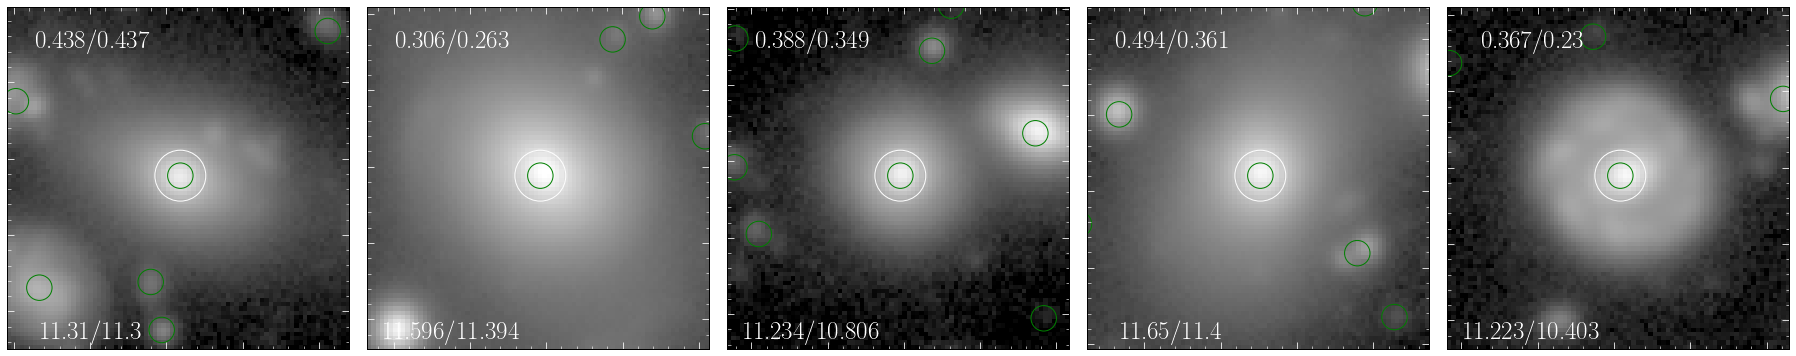

In [61]:
fig = plt.figure(figsize=(25, 5))

for i, gal in enumerate(massive_gals_selected_z[5:10]):
    row = i // 5
    col = i % 5
    
    print(gal['ID'],gal['Z_ML'],gal['lp_zPDF'],gal['MASS_MED_massrun'],gal['lp_mass_med'])
    
    # plot 
    gc = aplpy.FITSFigure('lp_massive_gal_check/cutout_'+str(gal['ID'])+'.fits',figure=fig,subplot=[0.1+col*0.2, 0.1+row*0.1, 0.19, 0.95])
    
    # cut cat_v9
    ra_cen,dec_cen = gal['RA'],gal['DEC']
    cat_v9_cut = cat_v9[abs(cat_v9['RA']-ra_cen)<10./3600]
    cat_v9_cut = cat_v9_cut[abs(cat_v9_cut['DEC']-dec_cen)<10./3600]
    gc.show_circles(cat_v9_cut['RA'],cat_v9_cut['DEC'],radius=0.5/3600.,color='green')
    
    gc.show_grayscale(stretch='log',vmin=2,vmax=5e3)
    gc.hide_yaxis_label()
    gc.hide_ytick_labels()
    gc.hide_xaxis_label()
    gc.hide_xtick_labels()
    
    gc.add_label(0.25,0.9,str(round(gal['Z_ML'],3))+'/'+str(round(gal['lp_zPDF'],3)),relative=True,fontsize=25,color='w')
    gc.add_label(0.25,0.05,str(round(gal['MASS_MED_massrun'],3))+'/'+str(round(gal['lp_mass_med'],3)),relative=True,fontsize=25,color='w')
    
    gc.show_circles(gal['RA'],gal['DEC'],radius=1/3600.,color='white')